COSC2671 Social Media and Network Analytics 

Assignment 2

@author Kunjar Supriya Rao (S3860925), RMIT University 2022
@author Priyanka Asokan (S3860273), RMIT University 2022
@author Reema Sunder Kumble (S3880556), RMIT University 2022

In [2]:
%load_ext autoreload
%autoreload 1
%aimport twitterClient
%aimport TwitterProcessing

/Users/ap/Desktop/Base_Folder/RMIT/Social Media/Assignment 2/code/Final/TwitterProcessing.py:47: DeprecationWarning: invalid escape sequence \s
  text = re.sub('@[^\s]+', '', text)
/Users/ap/Desktop/Base_Folder/RMIT/Social Media/Assignment 2/code/Final/TwitterProcessing.py:73: DeprecationWarning: invalid escape sequence \d
  regexDigit = re.compile("^\d+\s|\s\d+\s|\s\d+$")


In [1]:
import tweepy
import string
import json
import codecs
import re
import sys
import nltk
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emoji
import networkx as nx
from dateutil.parser import parse

import random
import time

import plotly.express as px
from nrclex import NRCLex

from tweepy import Cursor
from tweepy import TweepyException

from collections import Counter
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from colorama import Fore, Back, Style
from tweepy import api

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Data Collection

In [57]:
#lFields = ['author_id','entities','id','in_reply_to_user_id','referenced_tweets','text', 'created_at']
#query =  '#T20WorldCup lang:en'
#client = twitterClient.twitterClient()
#t20_data = tweepy.Paginator(client.search_recent_tweets, query=query,
#                          tweet_fields= lFields, max_results=100).flatten(limit =40000)

In [3]:
fJsonName = 'worldcup.jsonl'
tweetTokeniser = nltk.tokenize.TweetTokenizer()

Before we jump to cleaning process, we need to understand exactly how much data we have collected. To do that we will first get the `full_text` and `created_at` data for each tweet, put it in a dataframe and visualise. also the date is been reformatted

In [179]:
tweet_data = []
with open(fJsonName, 'r') as f:
    for item in f:
        dTweet = json.loads(item)   
        tweetText = dTweet.get('full_text', '')
        lTokens = tweetTokeniser.tokenize(tweetText) # to get the word count of the raw tweet
        tweetDate = dTweet.get('created_at')
        tweetDate = parse(tweetDate)
        tweetDate = tweetDate.strftime('%Y-%m-%dT%H:%M:%SZ')
        tweet_data.append([pd.to_datetime(tweetDate), len(lTokens)])

            text_length
date                   
2022-10-10           83
2022-10-11         5176
2022-10-12        10863
2022-10-13         8949
2022-10-14        18455
2022-10-15        49887
2022-10-16        41057
2022-10-17        51486
2022-10-18        31091
2022-10-19        10692


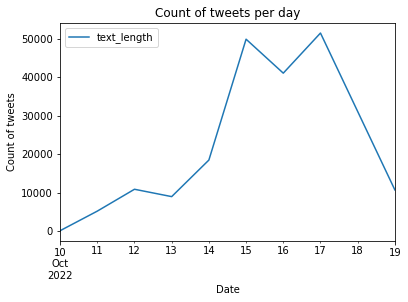

In [180]:
# create a dataframe and append date and word_length of the texts
series = pd.DataFrame(tweet_data, columns=['date', 'text_length']) 
new_series = pd.DataFrame(series.groupby([series['date'].dt.date])['text_length'].count())

# Tweets per day
print(new_series)

# date column is the one we use for indexing (or x-axis)
series.set_index('date', inplace=True)

newSeries = series.resample('1D').count()

# this plots and shows the time series
newSeries.plot()
plt.title('Count of tweets per day')
plt.xlabel('Date')
plt.ylabel('Count of tweets')
plt.show()

We follow the same procedure to find the count of tweets per hour.

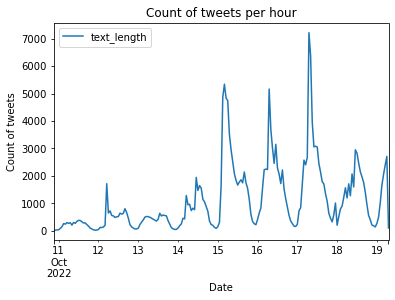

In [181]:
series = pd.DataFrame(tweet_data, columns=['date', 'text_length'])

# date column is the one we use for indexing (or x-axis)
series.set_index('date', inplace=True)

newSeries = series.resample('1H').count()
# the time series plot
newSeries.plot()
plt.title('Count of tweets per hour')
plt.xlabel('Date')
plt.ylabel('Count of tweets')
plt.show()

Next, understanding the maximum length of the tweets per day

            text_length
date                   
2022-10-10           53
2022-10-11           84
2022-10-12           67
2022-10-13           96
2022-10-14          101
2022-10-15          101
2022-10-16           84
2022-10-17           99
2022-10-18           77
2022-10-19           82


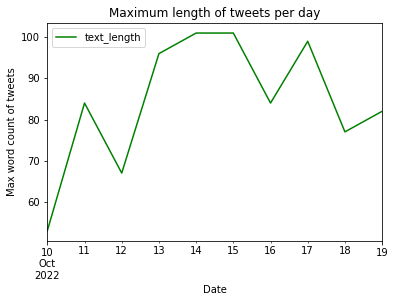

In [182]:
series = pd.DataFrame(tweet_data, columns=['date', 'text_length'])
new_series = pd.DataFrame(series.groupby([series['date'].dt.date])['text_length'].max())
print(new_series)

# date column is the one we use for indexing (or x-axis)
series.set_index('date', inplace=True)

newSeries = series.resample('1D').max()
# plots for time series
newSeries.plot(color = 'green')
plt.title('Maximum length of tweets per day')
plt.xlabel('Date')
plt.ylabel('Max word count of tweets')
plt.show()

Next, understanding the maximum length of the tweets per hour

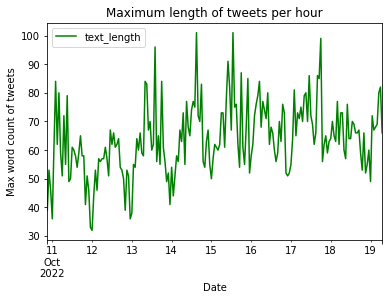

In [183]:
series = pd.DataFrame(tweet_data, columns=['date', 'text_length'])

# date column is the one we use for indexing (or x-axis)
series.set_index('date', inplace=True)

newSeries = series.resample('1H').max()
#  plot for time series
newSeries.plot(color = 'green')
plt.title('Maximum length of tweets per hour')
plt.xlabel('Date')
plt.ylabel('Max word count of tweets')
plt.show()

### Data Preparation and Data Cleaning

Before the cleaning we can analyse the most frequent terms, hashtags and mentions. We will perform this calculation for the top 50 <b>before</b> and <b>after</b> the cleaning
Post which we need to perform data cleaning process like below 
* Converting all text to lower case
* Converting emoji to text
* Remove the mentions
* Remove the hash(#) character from the hashtags
* Remove digits
* Tokenise the data
* Perform stemming on the tokenised text
* Removing URL having http or https
* Removing stop words
* Removing extra trailing and leading spaces from data after tokenisation

In [184]:
# display top 50 most commonly appearing words
freqNum = 50
termFreqCounter = Counter()
# open json file and process it tweet by tweet
with open(fJsonName, 'r') as f:
    for item in f:
        dTweet = json.loads(item)    
    
        tweetText = dTweet.get('full_text', '')
        
        # tokenise, filter stopwords and get convert to lower case
        lTokens = tweetTokeniser.tokenize(tweetText)         
        
        # update count
        termFreqCounter.update(lTokens)

# print out most common terms
for term, count in termFreqCounter.most_common(freqNum):
    print(term + ': ' + str(count))

:: 225922
RT: 188269
#T20WorldCup: 163427
the: 131212
…: 82553
.: 80920
in: 68148
,: 55367
to: 53004
!: 49224
of: 44467
a: 43494
|: 40408
for: 38118
and: 36803
@ICC: 30975
is: 28922
-: 26726
on: 24221
with: 23361
#TeamIndia: 22064
T20: 21466
’: 21458
🔥: 20769
s: 19588
World: 18776
?: 18588
️: 18444
Cup: 17729
at: 17313
will: 17205
@BCCI: 17089
2022: 16497
The: 16099
this: 15552
India: 15121
Pakistan: 15041
🇳: 14915
ICC: 14842
A: 14776
@T20WorldCup: 14677
has: 14475
Babar: 14071
by: 13589
from: 13544
🇮: 13455
up: 13424
): 13394
Australia: 13389
": 12664


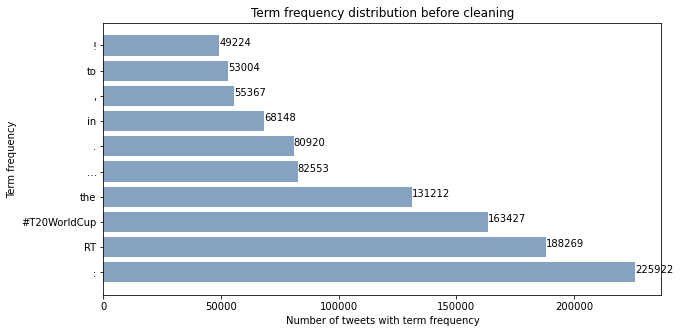

In [185]:
# Construct the x and y values
y = [count for tag, count in termFreqCounter.most_common(10)]
x = [tag for tag, count in termFreqCounter.most_common(10)]
plt.figure(figsize=(10,5))
plt.barh(x, y,color=(0.2, 0.4, 0.6, 0.6))
plt.title("Term frequency distribution before cleaning")
plt.xlabel('Number of tweets with term frequency')
plt.ylabel('Term frequency')
 
for index, value in enumerate(y):
    plt.text(value, index,str(value))
plt.show()

It can be seen that there is lot of noise in the raw data and cannot be used for further analysis. Cleaning the raw data and then finding the top 50 frequent words.

In [186]:
# use the punctuation symbols defined in string.punctuation
lPunct = list(string.punctuation)

# use stopwords from nltk and a few other twitter specific terms like 'rt' (retweet)
lStopwords = nltk.corpus.stopwords.words('english') + lPunct + ['bb','tri','ht','xi','rt', 'via', '...', '…', 
                                                                '"', "'", '`', '©', '🇹','🇮','', '🇪', '.', 
                                                                ' ', 'thi','..','`','🇮','','🇪', '.', ' ',
                                                                '’', 'thi','/*;','⚘','wa','WA','ઇન્ડિયા','ગો','..',
                                                                '”','“','th','ti',':)','/*:','‘','ha','hi','im',
                                                                '🇳','𓃵','. . .','લેટસ','ઇન્ડિયા','લેટસ']

# our term frequency counter
termFreqCounter = Counter()
# creating a separate .py file which contains code for cleaning. This can be called multiple times as and when needed.
tweetProcessor = TwitterProcessing.TwitterProcessing(tweetTokeniser, lStopwords)

list_of_tokens = []
with open(fJsonName, 'r') as f:
    for item in f:
        dTweet = json.loads(item)    
    
        tweetText = dTweet.get('full_text', '')
        # tokenise, filter stopwords and get convert to lower case
        #lTokens = tweetTokeniser.tokenize(tweetText)         
        
        lTokens = tweetProcessor.process(tweetText)
        list_of_tokens.append(lTokens)

        # update count
        termFreqCounter.update(lTokens)

# print out most common terms
for term, count in termFreqCounter.most_common(freqNum):
    print(term + ': ' + str(count))

tworldcup: 172926
india: 30344
teamindia: 26067
pakistan: 22890
world: 21281
cup: 19618
fire: 17294
match: 16923
win: 16542
australia: 15740
icc: 15721
run: 15232
team: 15172
captain: 14533
babar: 14021
time: 13511
azam: 12822
birthday: 12778
namibia: 12762
cricket: 12096
camera_with_flash: 11859
one: 11823
good: 11439
game: 11105
virat: 10137
warm-up: 10116
star-struck: 10051
kohli: 9817
birthday_cak: 9569
cake: 9499
squad: 9448
look: 9333
men: 9279
happi: 8798
wehavewewil: 8736
selfi: 8369
beaming_face_with_smiling_ey: 8331
bowl: 8101
day: 8027
join: 7935
start: 7617
shami: 7556
viratkohli: 7498
first: 7422
play: 7268
sri: 7197
shaheen: 7193
rohit: 7146
live: 7099
best: 7067


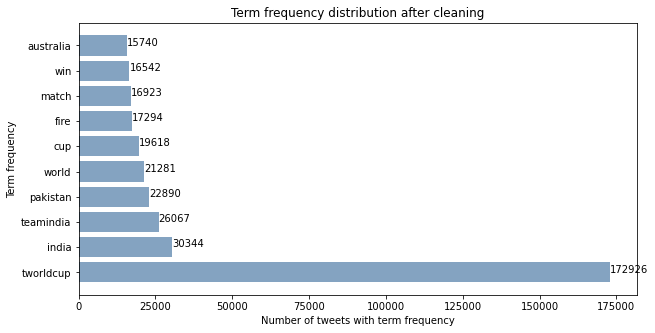

In [187]:
# Construct the x and y values
y = [count for tag, count in termFreqCounter.most_common(10)]
x = [tag for tag, count in termFreqCounter.most_common(10)]
plt.figure(figsize=(10,5))
plt.barh(x, y,color=(0.2, 0.4, 0.6, 0.6))
plt.title("Term frequency distribution after cleaning")
plt.xlabel('Number of tweets with term frequency')
plt.ylabel('Term frequency')
 
for index, value in enumerate(y):
    plt.text(value, index,str(value))
plt.show()

Analysing the most frequent <b> mentions </b> used in the corpus

In [188]:
def getMentions(tweet):
    """
    Extracts the associated mentions of tweet.

    @param tweet: The tweet, which is in the tweepy json format, and which we wish to extract its associated mentions.

    @returns: list of mentions (in lower case)
    """
    entities = tweet.get('entities', {})
    userMentions = entities.get('user_mentions', {})

    # not all tweets have mentions, hence we check for this and only retrieved the mentioned user if there is a mention
    if len(userMentions) > 0:
        lMentionedScreenName = [entry.get('screen_name', '') for entry in userMentions]
        return lMentionedScreenName
    else:
        return []

In [189]:
# number of tweets to display
tweetThres = 50

# open file and use Counter to count the number of times the mentions appears
with open(fJsonName, 'r') as f:
    mentionsCounter = Counter()
    for item in f:
        dTweet = json.loads(item)
    # for each line in file (which corresponds to a tweet), load it, get the mentions and insert them into the
    # Counter
    
        mentionsInTweet = getMentions(dTweet)
        mentionsCounter.update(mentionsInTweet)

    for mention, count in mentionsCounter.most_common(tweetThres):
        print(mention + ": " + str(count))

ICC: 31072
BCCI: 17096
T20WorldCup: 14759
TheRealPCB: 12121
ESPNcricinfo: 8165
imVkohli: 8137
babarazam258: 6919
Sportskeeda: 6335
ArfaSays_: 6287
StarSportsIndia: 5812
Cricketracker: 4854
grassrootscric: 4043
_FaridKhan: 3765
WasimJaffer14: 3630
ImRo45: 3465
RCBTweets: 3396
ChennaiIPL: 2986
MdShami11: 2905
SajSadiqCricket: 2610
RVCJ_FB: 2363
Trend_VKohli: 2167
mipaltan: 1829
iShaheenAfridi: 1825
ZimCricketv: 1816
FakharZamanLive: 1695
weRcricket: 1580
mr_lehsun: 1474
cricketcomau: 1473
cricketpakcompk: 1463
WisdenIndia: 1400
cricketaakash: 1372
THEVishalPawar: 1362
Flipkart: 1362
Lenovo: 1362
ChloeAmandaB: 1311
SAfridiOfficial: 1291
ChangeofPace414: 1221
fwildecricket: 1072
OfficialSLC: 1013
Clarkeyy23: 942
LucknowIPL: 892
CricWick: 892
Crickket__Video: 848
TheRock: 848
0xFanCraze: 838
KKRiders: 804
iihtishamm: 800
GettySport: 751
MazherArshad: 750
SanjanaGanesan: 736


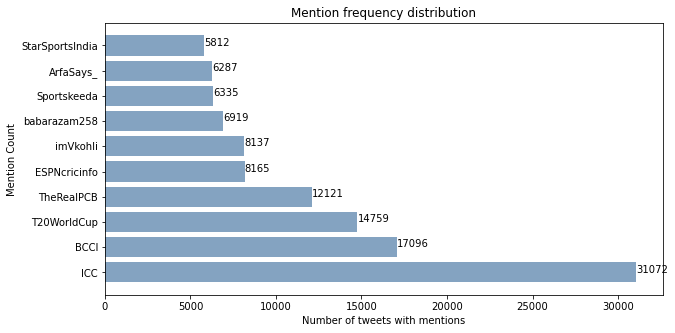

In [190]:
# Construct the x and y values
y = [count for tag, count in mentionsCounter.most_common(10)]
x = [tag for tag, count in mentionsCounter.most_common(10)]
plt.figure(figsize=(10,5))
plt.barh(x, y,color=(0.2, 0.4, 0.6, 0.6))
plt.title("Mention frequency distribution")
plt.xlabel('Number of tweets with mentions')
plt.ylabel('Mention Count')
 
for index, value in enumerate(y):
    plt.text(value, index,str(value))
plt.show()

Visualising the most common <b> hashtags </b> used in the corpus

In [191]:
def getHashtags(tweet):
    """
    Extracts the associated hashtags of tweet.

    @param tweet: The tweet, which is in the tweepy json format, and which we wish to extract its associated hashtags.

    @returns: list of hashtags (in lower case)
    """
    entities = tweet.get('entities', {})
    hashtags = entities.get('hashtags', [])

    return [tag['text'].lower() for tag in hashtags]

In [192]:
# number of tweets to display
tweetThres = 50

# open file and use Counter to count the number of times the hash tags appears
with open(fJsonName, 'r') as f:
    hashtagsCounter = Counter()
    for item in f:
        dTweet = json.loads(item)
    # for each line in file (which corresponds to a tweet), load it, get the hashtags and insert them into the
    # Counter
    
        hashtagsInTweet = getHashtags(dTweet)
        hashtagsCounter.update(hashtagsInTweet)

    for tag, count in hashtagsCounter.most_common(tweetThres):
        print(tag + ": " + str(count))

t20worldcup: 171922
teamindia: 26076
t20worldcup2022: 9269
wehavewewill: 8736
viratkohli: 7517
cricket: 5891
crickettwitter: 5346
rohitsharma: 5057
indvaus: 4743
slvnam: 4712
believeinblue: 4273
t20: 4030
indvpak: 3472
newcoverpic: 3419
ausvind: 3058
indiancricketteam: 2968
t20wc2022: 2668
indvsaus: 2649
indvspak: 2644
viratkohli𓃵: 2595
pakistan: 2359
india: 2354
bb16: 2301
biggboss16: 2279
slvsnam: 2181
prabhas: 2141
varisu: 2077
biggbosstelugu6: 2071
babarazam: 2045
playbold: 2014
whistlepodu: 1807
onefamily: 1739
pakveng: 1688
zimvire: 1493
godfather: 1455
readyfort20wc: 1442
namibia: 1404
slvuae: 1378
pakvafg: 1374
rohitsharma𓃵: 1330
teampakistan: 1278
srilanka: 1271
pakvnz: 1190
ponniyinselvan1: 1174
banadipurush: 1170
adipurushteaser: 1169
wivsco: 1168
shami: 1164
greatestrivalry: 1133
babarazam𓃵: 1034


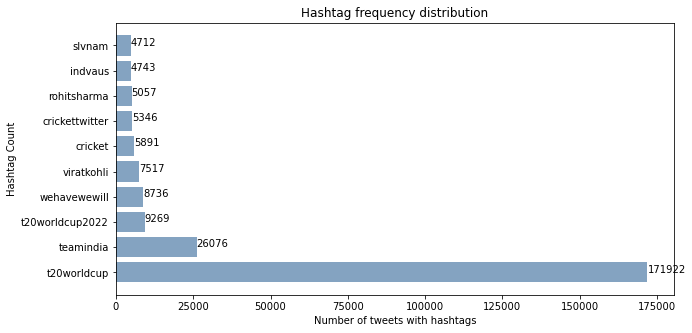

In [193]:
from matplotlib.pyplot import figure

# Construct the x and y values
y = [count for tag, count in hashtagsCounter.most_common(10)]
x = [tag for tag, count in hashtagsCounter.most_common(10)]
plt.figure(figsize=(10,5))
plt.barh(x, y,color=(0.2, 0.4, 0.6, 0.6))
plt.title("Hashtag frequency distribution")
plt.xlabel('Number of tweets with hashtags')
plt.ylabel('Hashtag Count')
 
for index, value in enumerate(y):
    plt.text(value, index,str(value))
plt.show()

### Part 2 - Understanding the sentiments behind the tweets

#### First Approach - Using basic count word sentiment analysis

In [23]:
def countWordSentimentAnalysis(setPosWords, setNegWords, sTweetsFilename, bPrint, tweetProcessor):
    """
    Basic sentiment analysis.  Count the number of positive words, count the negative words, overall polarity is the
    difference in the two numbers.

    @param setPosWords: set of positive sentiment words
    @param setNegWords: set of negative sentiment words
    @param sTweetsFilename: name of input file containing a json formated tweet dump
    @param bPrint: whether to print the stream of tokens and sentiment.  Uses colorama to highlight sentiment words.
    @param tweetProcessor: TweetProcessing object, used to pre-process each tweet.

    @returns: list of tweets, in the format of [date, sentiment]
    """


    lSentiment = []
    count_pos = 0
    count_neg = 0
    count_neutral = 0

    # open file and process tweets, one by one
    with open(sTweetsFilename, 'r') as f:
        for line in f:
            posNum=0
            negNum =0
            # each line is loaded according to json format, into tweet, which is actually a dictionary
            tweet = json.loads(line)

            try:
                tweetText = tweet.get('full_text', '')
                tweetDate = tweet.get('created_at')
                tweetDate = parse(tweetDate)
                tweetDate = tweetDate.strftime('%Y-%m-%dT%H:%M:%SZ')
                # pre-process the tweet text
                # Although we have already pre processed the text, we had not included the `created_at` data.
                # therefore calling the process method again
                lTokens = tweetProcessor.process(tweetText) 
                
                # identify all the positive words and then take the count of it  
                posNum = len([tok for tok in lTokens if tok in setPosWords])
#                 for tok in lTokens:
#                     if tok in setPosWords:
#                         posNum +=1
                        
#                     elif tok in setNegWords:
#                         negNum +=1
                                           
                        
                
                # identify all the negative words and then take the count of it 
                negNum = len([tok for tok in lTokens if tok in setNegWords])
                
                # Sentiment is obtained by the difference of positive and negative words
                sentiment = posNum - negNum
                if sentiment == 0:
                    count_neutral +=1
                elif sentiment >0:
                    count_pos += 1
                elif sentiment <0:
                    count_neg += 1
                    
                
                

                # save the date and sentiment of each tweet (used for time series)
                lSentiment.append([pd.to_datetime(tweetDate), sentiment])

                # if we are printing, each token is printed and coloured according to green if positive word, and red
                # if negative
                if bPrint:
                    for token in lTokens:
                        if token in setPosWords:
                            print(Fore.GREEN + token + ', ', end='')
                        elif token in setNegWords:
                            print(Fore.RED + token + ', ', end='')
                        else:
                            print(Style.RESET_ALL + token + ', ', end='')

                    print(': {}'.format(sentiment))


            except KeyError as e:
                pass

    return lSentiment, count_pos,count_neg,count_neutral


#### Approach 2 - Using vader to analyse the sentiments

In [24]:
def vaderSentimentAnalysis(sTweetsFilename, bPrint, tweetProcessor):
    """
    Use Vader lexicons instead of a raw positive and negative word count.

    @param sTweetsFilename: name of input file containing a json formated tweet dump
    @param bPrint: whether to print the stream of tokens and sentiment.  Uses colorama to highlight sentiment words.
    @param tweetProcessor: TweetProcessing object, used to pre-process each tweet.

    @returns: list of tweets, in the format of [date, sentiment]
    """

    # initialising the vader analyser
    sentAnalyser = SentimentIntensityAnalyzer()


    lSentiment = []
    pos_count = 0
    neg_count = 0
    neutral_count = 0

    # open file and process tweets, one by one
    with open(sTweetsFilename, 'r') as f:
        for line in f:
            # each line is loaded according to json format, into tweet
            tweet = json.loads(line)

            try:
                tweetText = tweet.get('full_text', '')
                tweetDate = tweet.get('created_at')
                tweetDate = parse(tweetDate)
                tweetDate = tweetDate.strftime('%Y-%m-%dT%H:%M:%SZ')
                # pre-process the tweet text
                lTokens = tweetProcessor.process(tweetText)

                # computing the sentiment scores                
                dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))
                #dSentimentScores = sentAnalyser.polarity_scores(tweetText)

                # save the date and sentiment of each tweet 
                lSentiment.append([pd.to_datetime(tweetDate), dSentimentScores['compound']])

                # print the tokens then the sentiment scores if want to print.  
                if bPrint:
                    print(*lTokens, sep=', ')
                    for cat,score in dSentimentScores.items():
                        print('{0}: {1}, '.format(cat, score), end='')
                    print()
                
                print("Sentence Overall Rated As", end = " ")
                # decide sentiment as positive, negative and neutral
                # For each sentence printing the 
                if dSentimentScores['compound'] >= 0.05 :
                    print("Positive")
                    pos_count +=1
                    
 
                elif dSentimentScores['compound'] <= - 0.05 :
                    neg_count +=1
                    print("Negative")
            
 
                else :
                    print("Neutral")
                    neutral_count +=1
                print()           
                

            except KeyError as e:
                pass                      


    return lSentiment,pos_count,neg_count,neutral_count

In [25]:
# input file of set of postive words from movie reviews from the lecture material
posWordFile = 'positive-words.txt'

# input file of set of negative words
negWordFile = 'negative-words.txt'

# flag to determine whether to print out tweets and their sentiment
flagPrint = True

In [26]:
# load set of positive words
lPosWords = []
with open(posWordFile, 'r', encoding='utf-8', errors='ignore') as fPos:
    for sLine in fPos:
        lPosWords.append(sLine.strip())

setPosWords = set(lPosWords)


# load set of negative words
lNegWords = []
with codecs.open(negWordFile, 'r', encoding='utf-8', errors='ignore') as fNeg:
    for sLine in fNeg:
        lNegWords.append(sLine.strip())

setNegWords = set(lNegWords)

### Count Analysis

In [1]:
# compute the sentiment
lSentiment_count = []
lSentiment_count, count_pos, count_neg, count_neutral = countWordSentimentAnalysis(setPosWords, setNegWords, fJsonName, flagPrint, tweetProcessor)

In [54]:
# Count of postive, negative and neutral 
# tweets for Word Count Analyser
print("Word Count Analyser method")
print("Positive count:", count_pos)
print("Negative count:",count_neg)
print("Neutral count:",count_neutral)

Word Count Analyser method
Positive count: 65307
Negative count: 17442
Neutral count: 144990


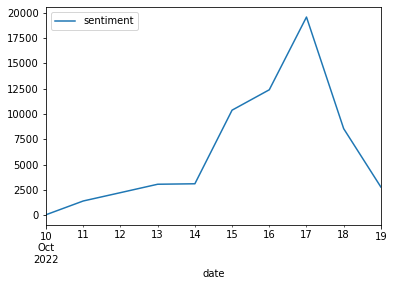

In [55]:
# Line graph to display the sentiment score against its date by resampling it by day and hour

# convert lSentiment to a dataframe series using pandas 
count_series = pd.DataFrame(lSentiment_count, columns=['date', 'sentiment'])

# indexing the date column
count_series.set_index('date', inplace=True)

# convert the sentiment score to numeric datatype
count_series[['sentiment']] = count_series[['sentiment']].apply(pd.to_numeric)

# Plot the line grah by day
newSeries = count_series.resample('1D').sum()
newSeries.plot()
plt.show()

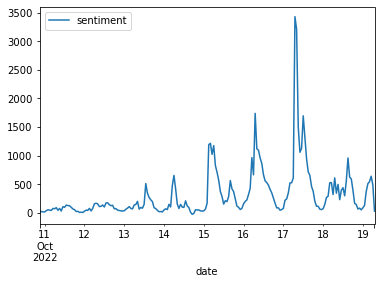

In [56]:
# Plot the line grah by hour
newSeries = count_series.resample('1H').sum()
newSeries.plot()
plt.show()

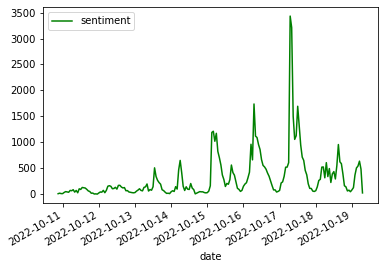

In [57]:
# Plot the line grah by hour for positive sentiments
newSeriesH = count_series.resample('1H').sum()
newSeriesH[newSeriesH['sentiment']>0].plot(color="green")
plt.show()

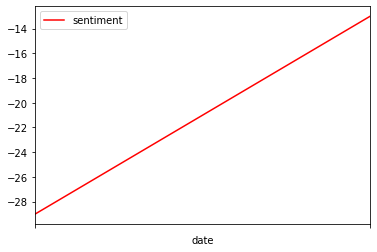

In [60]:
# Plot the line grah by hour for negative sentiments
newSeriesH = count_series.resample('1H').sum()
newSeriesH[newSeriesH['sentiment']<0].plot(color="red")
plt.show()

In [62]:
newSeriesH[newSeriesH['sentiment']<0]

sentiment
date                                
2022-10-14 17:00:00+00:00        -29
2022-10-14 18:00:00+00:00        -13

The above count sentiment analysis result shows the tokenised text for each tweet having green color for positive word and red color for negative word along with the sentiment score of the tweet. In this analysis we can observe that the overall sentiment of the tweets are positive when considered on a hourly basis.

### Vader Analysis

In [2]:
#calling the vader
lSentiment_vader =[]
lSentiment_vader, pos_count, neg_count, neutral_count = vaderSentimentAnalysis(fJsonName, flagPrint, tweetProcessor)

In [69]:
# Count of postive, negative and neutral 
# tweets for Word Count Analyser
print("Word Count Analyser method")
print("Positive count:", pos_count)
print("Negative count:",neg_count)
print("Neutral count:",neutral_count)

Word Count Analyser method
Positive count: 85590
Negative count: 26269
Neutral count: 115880


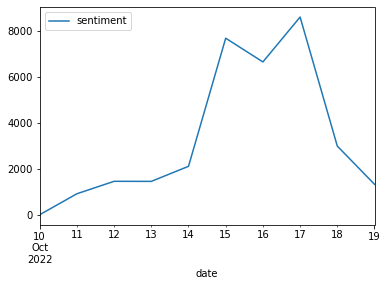

In [70]:
# Line graph to display the sentiment score against its date by resampling it by day and hour

# convert lSentiment to a dataframe series using pandas 
vader_series = pd.DataFrame(lSentiment_vader, columns=['date', 'sentiment'])

# indexing the date column
vader_series.set_index('date', inplace=True)

# convert the sentiment score to numeric datatype
vader_series[['sentiment']] = vader_series[['sentiment']].apply(pd.to_numeric)

# Plot the line grah by day
newSeries = vader_series.resample('1D').sum()
newSeries.plot()
plt.show()

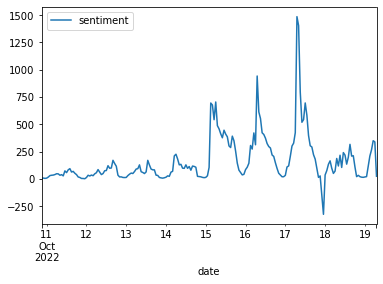

In [71]:
# Plot the line grah by hour
newSeries = vader_series.resample('1H').sum()
newSeries.plot()
plt.show()

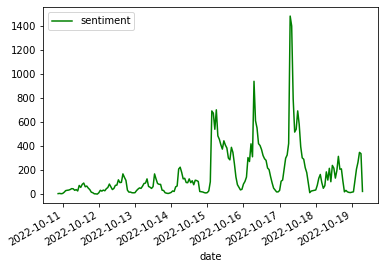

In [72]:
# Plot the line grah by hour for positive sentiments
newSeriesH = vader_series.resample('1H').sum()
newSeriesH[newSeriesH['sentiment']>0].plot(color="green")
plt.show()

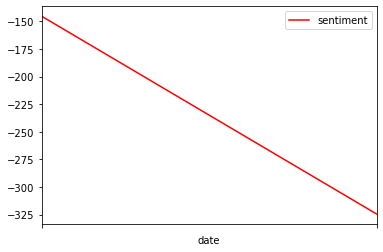

In [73]:
# Plot the line grah by hour for negative sentiments
newSeriesH = vader_series.resample('1H').sum()
newSeriesH[newSeriesH['sentiment']<0].plot(color="red")
plt.show()

In [74]:
newSeriesH[newSeriesH['sentiment']<0]

sentiment
date                                
2022-10-17 22:00:00+00:00  -145.2700
2022-10-17 23:00:00+00:00  -324.4189

The above vader analysis result shows the tokenised text for each tweet an individual score for positive, negative and neytral emotion along with its intensity of emotion. Hence the value will be rangiong from 0 to 1 for each category. The intenisty of the emotion can be observed from the compound score. Here we can observe that the sentiment of all the tweets are mostly positive excet for a sharp dip on oct 18 2022 when considered on a hourly basis.

### Topic Modelling

In [194]:
lTweets = []
len_tokens = 0
with open(fJsonName, 'r') as f:
    for line in f:
        
        # each line is loaded according to json format, into tweet, which is actually a dictionary
        tweet = json.loads(line)        
        tweetText = tweet.get('full_text', '')
        lTokens = tweetProcessor.process(tweetText)
        len_tokens = len_tokens +len(lTokens) 
        lTweets.append(' '.join(lTokens))        

In [170]:
topicNum = 5

# maximum number of words to display per topic
wordNumToDisplay = 10

# generating 1000 features
featureNum = 1500

In [171]:
tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(lTweets)
# extract the names of the features (in our case, the words)
tfFeatureNames = tfVectorizer.get_feature_names()

# Run LDA (see documentation about what the arguments means)
ldaModel = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

In [172]:
def display_topics(model, featureNames, numTopWords):
    """
    Prints out the most associated words for each feature.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    @param numTopWords: number of words to print per topic.
    """

    # print out the topic distributions
    for topicId, lTopicDist in enumerate(model.components_):
        print("Topic %d:" % (topicId))
        print(" ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]]))

In [173]:
display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)

Topic 0:
tworldcup kohli team squad india viratkohli run australia pakistan warm
Topic 1:
tworldcup kohli time namibia selfi live believeinblu bowl sri lanka
Topic 2:
viratkohli tworldcup virat look beaming_face_with_smiling_ey kohli oct onward eye like
Topic 3:
tworldcup star babar azam captain pakistan struck kohli shami best
Topic 4:
tworldcup viratkohli cup world icc virat teamindia birthday india men


In [174]:
def displayWordcloud(model, featureNames):
    """
    Displays the word cloud of the topic distributions, stored in model.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    """

    # this normalises each row/topic to sum to one
    # use this normalisedComponents to display your wordclouds
    normalisedComponents = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]


    
    topicNum = len(model.components_)
    # number of wordclouds for each row
    plotColNum = 3
    # number of wordclouds for each column
    plotRowNum = int(math.ceil(topicNum / plotColNum))

    for topicId, lTopicDist in enumerate(normalisedComponents):
        lWordProb = {featureNames[i] : wordProb for i,wordProb in enumerate(lTopicDist)}
        wordcloud = WordCloud(background_color='black',width=1300, height=1000)
        wordcloud.fit_words(frequencies=lWordProb)
        plt.figure(figsize=(30, 30))
        plt.subplot(plotRowNum, plotColNum, topicId+1)
        plt.title('Topic %d:' % (topicId+1))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

    plt.show(block=True)

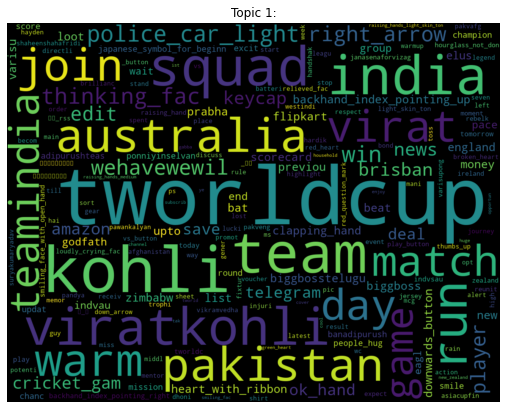

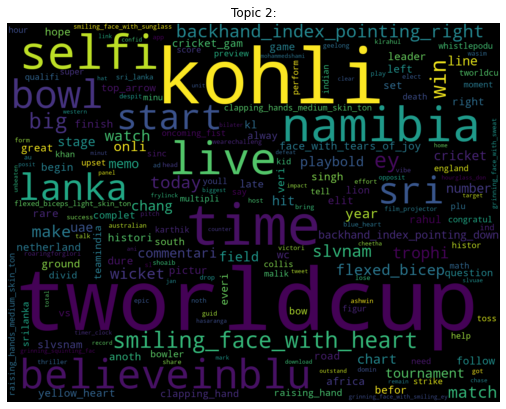

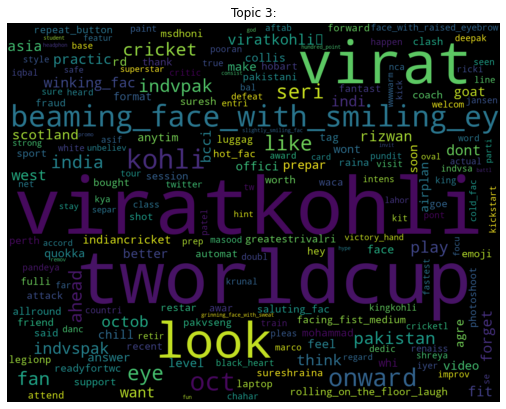

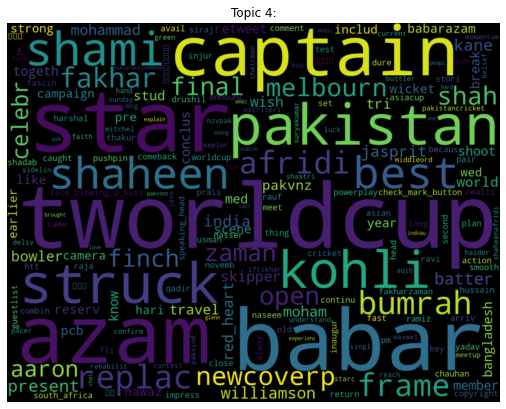

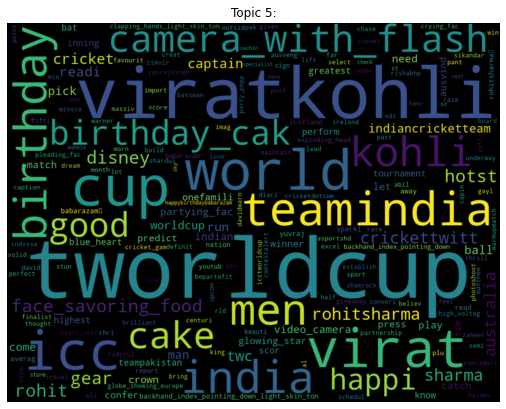

In [175]:
displayWordcloud(ldaModel, tfFeatureNames)

Out of all the 5 topics shown above we can observe that one player name has popped up in all the topics due to which we can infer saying that the most famous player in the t20 world cup series till now is 'VIRAT KOHLI'

### Emotion Analysis

This analysis is performed to calculate the different emotions of the tweet dataset we have. The result categories are given below. From this result we can infer that the most popular emotion amoung the tweet is 'POSITIVE'

In [195]:
str_tweet = ','.join(lTweets)
text_object = NRCLex(str_tweet)

In [196]:
data = text_object.raw_emotion_scores

In [197]:
data

{'joy': 69573,
 'positive': 151411,
 'trust': 85937,
 'anticipation': 103067,
 'surprise': 58403,
 'negative': 51614,
 'fear': 45305,
 'sadness': 13905,
 'anger': 26017,
 'disgust': 5059}

In [198]:
emotion_df = pd.DataFrame.from_dict(data, orient='index')
emotion_df = emotion_df.reset_index()
emotion_df = emotion_df.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
emotion_df = emotion_df.sort_values(by=['Emotion Count'], ascending=False)

fig = px.bar(emotion_df, x='Emotion Count', y='Emotion Classification', color = 'Emotion Classification', orientation='h', width = 800, height = 400)
fig.show()

In [199]:
affect_df = pd.DataFrame.from_dict(text_object.affect_dict, orient='index')

In [200]:
text_object.affect_frequencies

{'fear': 0.0742350780201576,
 'anger': 0.04263048283523762,
 'anticip': 0.0,
 'trust': 0.1408131530696012,
 'surprise': 0.09569697078934475,
 'positive': 0.24809639991413932,
 'negative': 0.08457276938378577,
 'sadness': 0.022784212777183344,
 'disgust': 0.008289488129433337,
 'joy': 0.1139997148901098,
 'anticipation': 0.16888173019100725}

In [201]:
emotion_df = pd.DataFrame.from_dict(text_object.affect_frequencies, orient='index')
emotion_df = emotion_df.reset_index()
emotion_df = emotion_df.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
emotion_df = emotion_df.sort_values(by=['Emotion Count'], ascending=False)

fig = px.bar(emotion_df, x='Emotion Count', y='Emotion Classification', 
             color='Emotion Count', color_continuous_scale='Inferno')
fig.show()